In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
import hankl
%matplotlib inline

# Calculate $C_l^{\Delta \phi}(k)$

Text(0.5, 1.0, 'Fiducial')

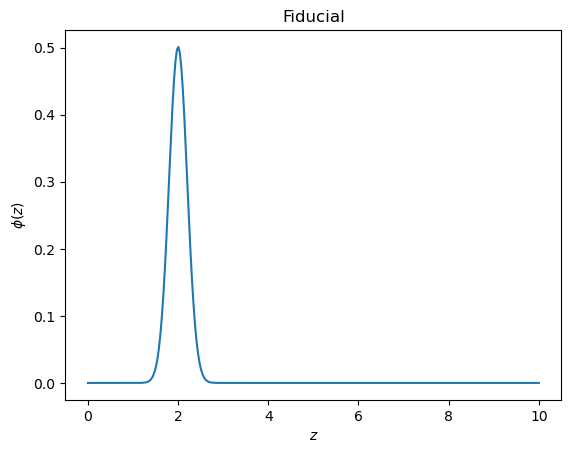

In [15]:
sigma = 0.2 # Standard deviation of the fiducial dndz
sigma_zshift = 0.2 # Standard deviation of the z_shift
z_mean = 2 # Central redshift of the nominal dndz

# Plot the fiducial dndz
zs = np.linspace(0,10,300)
dndz_fid = sigma*np.sqrt(2*np.pi)*np.exp(-(zs - z_mean)**2 /(2*sigma**2))
plt.plot(zs, dndz_fid)
plt.ylabel(r'$\phi(z)$')
plt.xlabel(r'$z$')
plt.title('Fiducial')

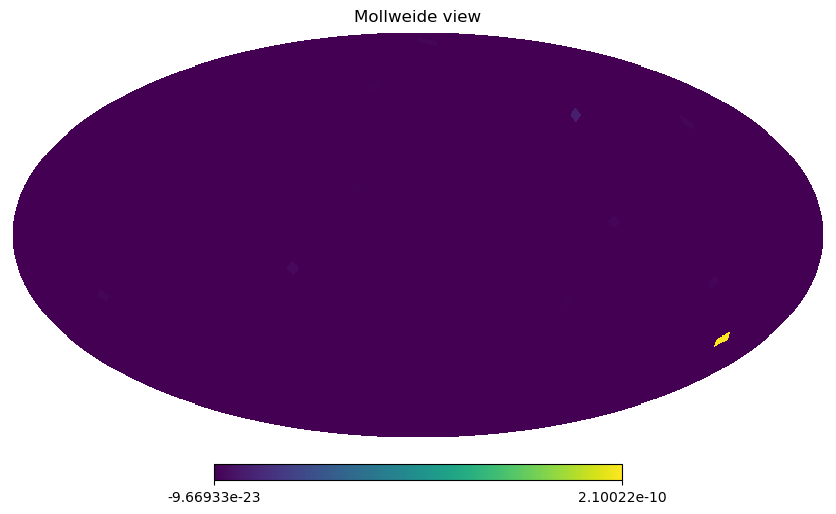

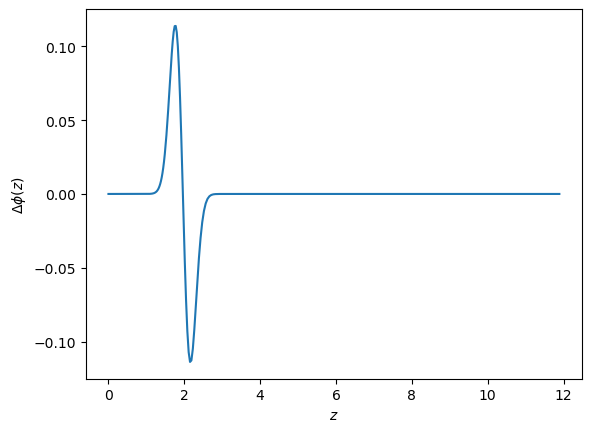

In [16]:
# Suppose the central value of the dndz changes across different healpixels
nside = 16 # Nside that sets the size of pixels over which dn/dz is constant
npix = hp.nside2npix(nside)

# Initialize samples in r to be used in FFTLog calculation of the Hankel transforms
n_samples_of_r = 2**11
log_rmin = -4
log_rmax = 4
r_array = np.logspace(log_rmin,log_rmax,n_samples_of_r) 
# Get the redshift corresponding to these values of r in the Planck18 cosmology
z_array = np.zeros((npix, n_samples_of_r))
for i, r in enumerate(r_array):
    z_array[:, i] = z_at_value(Planck18.comoving_distance, r* u.Mpc)  

# Draw random values in each pixel for the shift of the central redshift of the dndz
shifts_array = np.random.normal(loc=0, scale=sigma_zshift, size=npix)

# Calculate the perturbation to the dndz in each pixel and each r slice
theta_maps = sigma*np.sqrt(2*np.pi)*(np.exp(-(z_array - z_mean - shifts_array[..., np.newaxis])**2 /(2*sigma**2)) - np.exp(-(z_array - z_mean )**2 /(2*sigma**2)))
hp.mollview(theta_maps[:,0])
plt.show()

# Plot the Delta phi (z) at a random pixel
pix_idx = np.random.randint(0, npix)
plt.plot(z_array[pix_idx,:], theta_maps[pix_idx,:])
plt.ylabel(r'$\Delta \phi(z)$')
plt.xlabel(r'$z$')
plt.show()

In [17]:
# Let us up-sample the maps
nside_out = 128

theta_maps_upsampled = np.zeros((hp.nside2npix(nside_out), n_samples_of_r))
for i in range(len(r_array)):
    theta_maps_upsampled[:,i] = hp.ud_grade(theta_maps[:,i], nside_out)
    
theta_maps = theta_maps_upsampled

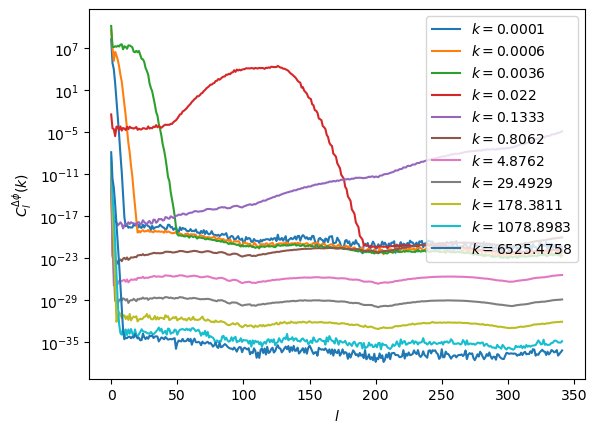

In [18]:
# Take the spherical harmonic transform of each r slice. Conveniently, we can take complex SHT so array sizes reduce by x2
theta_alms = np.zeros((hp.Alm.getsize(3*nside_out-1), n_samples_of_r), dtype=complex)
for i in range(n_samples_of_r):
    theta_alms[:,i] = hp.map2alm(theta_maps[:,i])

# Next, we will want to take the (l+1/2)th order Hankel transform of each theta_alm
delta_p_lm_of_k = np.zeros((theta_alms.shape[0], n_samples_of_r), dtype=complex) 
lmax = hp.Alm.getlmax(len(delta_p_lm_of_k))
Cl_deltap_of_k = np.zeros((lmax+1, n_samples_of_r))
pixwinf = hp.pixwin(nside_out)[0:lmax+1] # Get the pixel window function for the up-sampled pixelization

for i in range(len(delta_p_lm_of_k)):
    l, m = hp.Alm.getlm(lmax, i) # Get the l corresponding to each value of m
    k_array, delta_p_lm_of_k[i,:] = hankl.FFTLog(r_array, r_array*theta_alms[i,:], q=0, mu=l+0.5, ext=1, lowring=True)
    delta_p_lm_of_k[i,:] *= 1./k_array # Adapt to the convention in the Hankl code
    # Get angular PS and deconvolve pixel window function
    Cl_deltap_of_k[l,:] += (delta_p_lm_of_k[i,:] * np.conj(delta_p_lm_of_k[i,:])).real/ (2*l+1) / pixwinf[l]**2

for k_idx, k in zip(np.arange(len(k_array))[::200], k_array[::200]):
    plt.semilogy(Cl_deltap_of_k[:,k_idx], label=r'$k={}$'.format(round(k, 4)))
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{\Delta \phi}(k)$')
plt.legend()

The bumps at low l are actually physical!

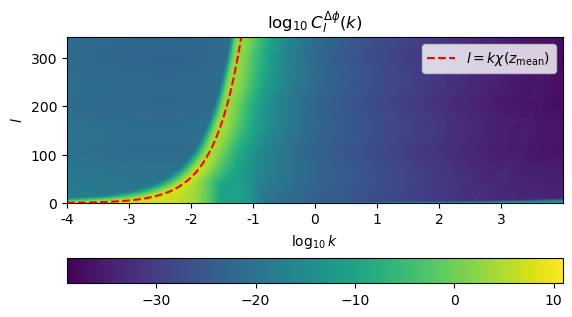

In [20]:
plt.imshow(np.log10(Cl_deltap_of_k[:,:]), aspect=2)

plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.plot(k_array*Planck18.comoving_distance(z_mean).value, color='r', ls='--', label=r'$l=k \chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax-40])

label_locs = np.arange(log_rmin, log_rmax, 1)
ax.set_xticks(np.arange(len(k_array))[::len(k_array)//len(label_locs)])
ax.set_xticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$\mathrm{log}_{10} \, C_l^{\Delta \phi}(k)$')
plt.colorbar(location='bottom')

Anisotropy can only be generated on scales smaller than the scale of the radial shift, and even then, only for $\ell<k \chi(z_{\mathrm{mean}})$

# Testing FFTLog

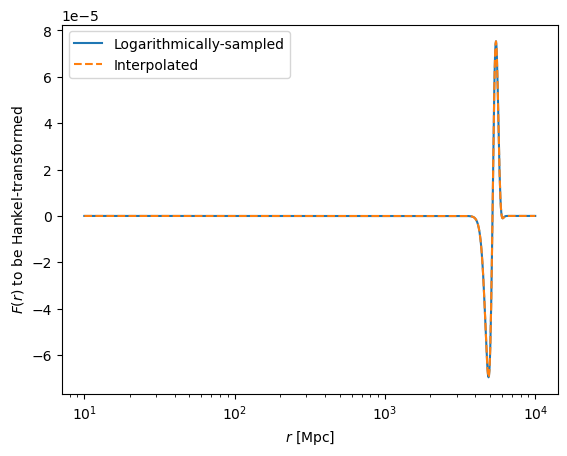

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.302540e-04
  warnings.warn(
/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_52719/1271661510.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value,
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 6.378440e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.551639e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.251540e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.888450e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.026770e-05
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.850818e-05
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarn

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.440603e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.454064e-03
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 4.673656e-03
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.238843e-03
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarn

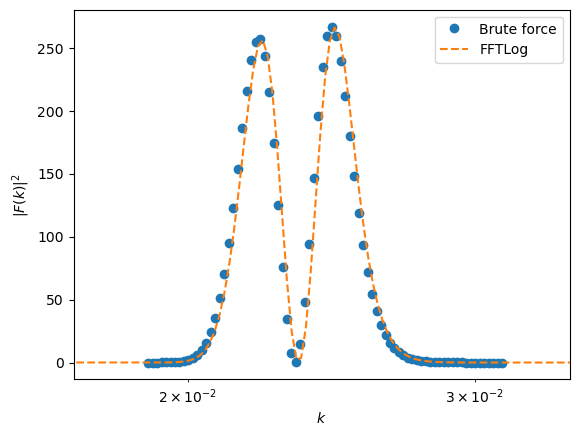

In [94]:
from scipy import interpolate
from scipy.integrate import quadrature
from scipy.special import jv

# Choose just one of the m's that we want to Hankel-transform. We will run our test on this one alone
test_idx = 500
# We will need the l corresponding to this m to compute the (l+0.5)th order Hankel transform
test_l, test_m = hp.Alm.getlm(lmax, test_idx) 

# Interpolate the function to be Hankel transformed so we can do it by brute-force
inter_func = interpolate.interp1d(r_array, theta_alms[test_idx,:], bounds_error=True)
plt.semilogx(r_array, theta_alms[test_idx,:], label='Logarithmically-sampled')
plt.semilogx(r_array, inter_func(r_array), ls='--', label='Interpolated')
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$F(r)$ to be Hankel-transformed')
plt.legend()
plt.show()

# First, integrate using FFTLog
test_k_array, test_delta_p_lm_of_k = hankl.FFTLog(r_array, r_array*theta_alms[test_idx,:], q=0, 
                                                  mu=test_l+0.5, ext=2, lowring=True)
result_fftlog = test_delta_p_lm_of_k*np.conj(test_delta_p_lm_of_k)/test_k_array**2

# Compare to a brute-force numerical integration
def integrand(r, k, test_l):
    # The integrand of the Hankel transform we want
    return inter_func(r) * r * jv(test_l + 0.5, k*r)

# Use the FFTlog calculation to refine the domain overwhich we do brute force
log_kmin_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][0]])
log_kmax_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][-1]])

shortened_test_k_array = np.logspace(log_kmin_bruteforce, log_kmax_bruteforce, 80)
p_lm_singlek = np.zeros_like(shortened_test_k_array)
err = np.zeros_like(shortened_test_k_array)
for i, test_k in enumerate(shortened_test_k_array):
    # At a few values of k, get the Hankel transform by brute force
    p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value, 
                                   Planck18.comoving_distance(10).value, args=(test_k, test_l),
                                         rtol=0.0000001, maxiter=1000)

plt.semilogx(shortened_test_k_array, p_lm_singlek*np.conj(p_lm_singlek), ls='none', marker='o', label='Brute force')
plt.semilogx(test_k_array, result_fftlog, ls='--', label='FFTLog')
plt.xlabel(r'$k$')
plt.ylabel(r'$|F(k)|^2$')
plt.xlim([10**log_kmin_bruteforce*0.9, 10**log_kmax_bruteforce*1.1])
plt.legend()